# Reference Link
https://www.kaggle.com/yashvi/vehicle-insurance-eda-and-boosting-models

https://www.kaggle.com/roshankumarg/rank-10-solution-cross-sell-prediction-hackathon

https://www.kaggle.com/isaienkov/insurance-prediction-eda-and-modeling-acc-88

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# for visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# import holoviews as hv

# Testing
import scipy
import scipy.stats as st


from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


# hv.extension('bokeh')

%matplotlib inline

In [2]:
print('Numpy Version : ' + np.__version__)
print('Pandas Version : ' + pd.__version__)
print('Matplotlib Version : ' + matplotlib.__version__)
print('Seaborn Version : ' + sns.__version__)
print('Scipy Version : ' + scipy.__version__)

Numpy Version : 1.19.2
Pandas Version : 1.1.3
Matplotlib Version : 3.3.2
Seaborn Version : 0.11.0
Scipy Version : 1.5.2


<h1>DATA DESCRIPTION</h1>

In [3]:
from IPython.display import Image

Image(url= "archive/data-description.png", width=1000)

In [4]:
train = pd.read_csv('archive/train.csv')
test = pd.read_csv('archive/test.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Target Output : Feature <strong>RESPONSE</strong>

<h1>DATA CLEANING</h1>

In [5]:
train.shape

(381109, 12)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [7]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [8]:
# Finding Missing Value
data_missing_value = train.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value = data_missing_value[data_missing_value['missing_value'] > 0]

data_missing_value

,feature,missing_value


In [9]:
# Finding Duplicates
train.duplicated().sum()

0

In [10]:
#Invalid Value
display(train.select_dtypes(include=['object']).columns)
print(train.select_dtypes(include=object).shape)
data_cat = train.select_dtypes(include=['object'])

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

(381109, 3)


In [11]:
train['Gender'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [12]:
train['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [13]:
train['Vehicle_Damage'].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [14]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(train.select_dtypes(include=numerics).columns)
print(train.select_dtypes(include=numerics).shape)
data_num = train.select_dtypes(include=numerics)

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

(381109, 9)


In [15]:
train[['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']].describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [16]:
train[['Gender', 'Vehicle_Age', 'Vehicle_Damage']].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


<h1>EXPLORATORY DATA ANALYST</h1>

In [17]:
trainGroup = train.loc[:, train.columns.intersection(['id', 'Response'])]
trainGroup['Age-Group'] = train['Age'].apply(lambda x : '> 50' if x > 50 else ('36 - 50' if (x > 35) and (x < 51) else '20-35'))
trainGroup['Vintage-Group'] = train['Vintage'].apply(lambda x : '0-100' if x < 100 else ('100 - 200' if (x > 100) and (x < 200) else '200 - 300'))
trainGroup['Annual_Premium-Group'] = train['Annual_Premium'].apply(lambda x : '> 450K' if x > 450000 else ('150K - 450K' if (x > 150000) and (x < 450001) else '0 - 150K'))

trainGroup

,id,Response,Age-Group,Vintage-Group,Annual_Premium-Group
0,1,1,36 - 50,200 - 300,0 - 150K
1,2,0,> 50,100 - 200,0 - 150K
2,3,1,36 - 50,0-100,0 - 150K
3,4,0,20-35,200 - 300,0 - 150K
4,5,0,20-35,0-100,0 - 150K
...,...,...,...,...,...
381104,381105,0,> 50,0-100,0 - 150K
381105,381106,0,20-35,100 - 200,0 - 150K
381106,381107,0,20-35,100 - 200,0 - 150K
381107,381108,0,> 50,0-100,0 - 150K


In [18]:
# fig,ax = plt.subplots(1,2,figsize=(15,8),
#                      sharey=True)

# g = sns.countplot(train['Vehicle_Damage'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(train['Vehicle_Damage'], hue = train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])

# plt.suptitle('Response to Vehicle Damage',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold')

# fig.tight_layout();

In [19]:
# fig,ax = plt.subplots(1,2,figsize=(15,8),
#                      sharey=True)

# g = sns.countplot(train['Driving_License'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(train['Driving_License'], hue = train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])

# plt.suptitle('Response to Driving License',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold')

# fig.tight_layout();

In [20]:
# fig,ax = plt.subplots(1,2,figsize=(15,8),
#                      sharey=True)
# # 
# g = sns.countplot(train['Previously_Insured'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(train['Previously_Insured'], hue = train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])

# plt.suptitle('Response to Vehicle Damage',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold')

# fig.tight_layout();

In [21]:
# fig,ax = plt.subplots(1,2,figsize=(15,8),
#                      sharey=True)

# g = sns.countplot(train['Vehicle_Age'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(train['Vehicle_Age'], hue = train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])

# plt.suptitle('Response to Vehicle Age',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold');

# fig.tight_layout();

In [22]:
# fig,ax = plt.subplots(1,2,figsize=(15,8),
#                      sharey=True)

# g = sns.countplot(train['Gender'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(train['Gender'], hue = train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])

# plt.suptitle('Response to Gender',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold');

# fig.tight_layout();

In [23]:
# fig,ax = plt.subplots(1,4,figsize=(26,8))

# g = sns.countplot(trainGroup['Age-Group'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(trainGroup['Age-Group'], hue = trainGroup['Response'],palette=sns.color_palette("Set2"), ax=ax[1])
# g = sns.distplot(train['Age'], ax=ax[2])
# g = sns.boxplot(train['Age'], orient='v', ax=ax[3])

# plt.suptitle('Distribution Age',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold');

# fig.tight_layout();

In [24]:
# fig,ax = plt.subplots(1,4,figsize=(26,8))

# g = sns.countplot(trainGroup['Vintage-Group'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(trainGroup['Vintage-Group'], hue = trainGroup['Response'],palette=sns.color_palette("Set2"), ax=ax[1])
# g = sns.distplot(train['Vintage'], ax=ax[2])
# g = sns.boxplot(train['Vintage'], orient='v', ax=ax[3])

# plt.suptitle('Distribution Vintage',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold');
	
# fig.tight_layout();

In [25]:
# fig,ax = plt.subplots(1,4,figsize=(26,8))

# g = sns.countplot(trainGroup['Annual_Premium-Group'],palette=sns.color_palette("Set2"), ax=ax[0])
# g = sns.countplot(trainGroup['Annual_Premium-Group'], hue = trainGroup['Response'],palette=sns.color_palette("Set2"), ax=ax[1])
# g = sns.distplot(train['Annual_Premium'], ax=ax[2])
# g = sns.boxplot(train['Annual_Premium'], orient='v', ax=ax[3])

# plt.suptitle('Distribution Annual Premium Feature',y=1.05, fontsize=24,color='dodgerblue',fontweight='bold');
	
# fig.tight_layout();

In [26]:
# fig,ax = plt.subplots(2,figsize=(26,8),
#                      sharey=True)

# sns.countplot(train['Region_Code'],palette=sns.color_palette("Set2"), ax=ax[0])
# ax[0].set_title('Distribution Region Code')

# sns.countplot(train['Region_Code'],hue= train['Response'],palette=sns.color_palette("Set2"), ax=ax[1])
# ax[1].set_title('Response to Region Code')

# fig.tight_layout();

In [27]:
# features = ['Age', 'Annual_Premium', 'Vintage']
# plt.figure(figsize=(26, 8))

# for i in range(0, len(features)):
#     plt.subplot(1, 7, i+1)
#     sns.boxplot(train[features[i]],color='lime',orient='v')
#     plt.tight_layout()

In [28]:
# data_num = train[features]
# k = len(data_num.columns)
# n = 3
# m = (k - 1) // n + 1
# fig, axes = plt.subplots(m, n, figsize=(n * 8, m * 3))
# for i, (name, col) in enumerate(data_num.iteritems()):
#     r, c = i // n, i % n
#     ax = axes[r, c]
#     col.hist(ax=ax, color='green')
#     ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
#     ax2.set_ylim(0)

# fig.tight_layout()
# plt.savefig('fig/numerical distplot.png')

<h1>FEATURE ENGINEERING</h1>

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

ss = StandardScaler()

ss_list = [
    'Policy_Sales_Channel'
]

for x in ss_list :
    train[[x]] = ss.fit_transform(train[[x]])

In [30]:
train_m = train.merge(trainGroup[[
    'id', 
    'Age-Group', 
#     'Vintage-Group', 
#     'Annual_Premium-Group'
]], on='id')
train_m

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age-Group,Annual_Premium-Group
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,-1.587234,217,1,36 - 50,0 - 150K
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,-1.587234,183,0,> 50,0 - 150K
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,-1.587234,27,1,36 - 50,0 - 150K
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,0.737321,203,0,20-35,0 - 150K
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,0.737321,39,0,20-35,0 - 150K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,-1.587234,88,0,> 50,0 - 150K
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,0.737321,131,0,20-35,0 - 150K
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,0.884912,161,0,20-35,0 - 150K
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,0.220753,74,0,> 50,0 - 150K


In [31]:
train_m['Vehicle_Damage'] = train['Vehicle_Damage'].apply(lambda x : 1 if x == 'Yes' else 0)

In [32]:
train_dummies = pd.get_dummies(train_m[[
    'Gender', 
    'Vehicle_Age', 
    'Age-Group', 
#     'Vintage-Group', 
#     'Annual_Premium-Group'
]])
train_dummies.columns = [
    'Gender_Female', 
    'Gender_Male',
    'Vehicle_Age_1-2_Year', 
    'Vehicle_Age_<1_Year',
    'Vehicle_Age_>2_Year',
    'Age_20_35',
    'Age_36_50',
    'Age_>50',
#     'Vintage_0_100',
#     'Vintage_100_200',
#     'Vintage_200_300',
    'Annual_Premium_0_150K',
    'Annual_Premium_150K_450K',
    'Annual_Premium_>450K'  
]
train_d = pd.concat([train_m, train_dummies], axis=1)
train_d.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Gender_Male,Vehicle_Age_1-2_Year,Vehicle_Age_<1_Year,Vehicle_Age_>2_Year,Age_20_35,Age_36_50,Age_>50,Annual_Premium_0_150K,Annual_Premium_150K_450K,Annual_Premium_>450K
0,1,Male,44,1,28.0,0,> 2 Years,1,40454.0,-1.587234,...,1,0,0,1,0,1,0,1,0,0
1,2,Male,76,1,3.0,0,1-2 Year,0,33536.0,-1.587234,...,1,1,0,0,0,0,1,1,0,0
2,3,Male,47,1,28.0,0,> 2 Years,1,38294.0,-1.587234,...,1,0,0,1,0,1,0,1,0,0
3,4,Male,21,1,11.0,1,< 1 Year,0,28619.0,0.737321,...,1,0,1,0,1,0,0,1,0,0
4,5,Female,29,1,41.0,1,< 1 Year,0,27496.0,0.737321,...,0,0,1,0,1,0,0,1,0,0


In [33]:
train_d = train_d.drop([
    'id', 
    'Gender', 
    'Vehicle_Age', 
    'Region_Code', 
    'Age', 
    'Vintage', 
    'Annual_Premium',
    'Age-Group',
#     'Vintage-Group',
    'Annual_Premium-Group'
], axis=1)
train_d.head()

,Driving_License,Previously_Insured,Vehicle_Damage,Policy_Sales_Channel,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2_Year,Vehicle_Age_<1_Year,Vehicle_Age_>2_Year,Age_20_35,Age_36_50,Age_>50,Annual_Premium_0_150K,Annual_Premium_150K_450K,Annual_Premium_>450K
0,1,0,1,-1.587234,1,0,1,0,0,1,0,1,0,1,0,0
1,1,0,0,-1.587234,0,0,1,1,0,0,0,0,1,1,0,0
2,1,0,1,-1.587234,1,0,1,0,0,1,0,1,0,1,0,0
3,1,1,0,0.737321,0,0,1,0,1,0,1,0,0,1,0,0
4,1,1,0,0.737321,0,1,0,0,1,0,1,0,0,1,0,0


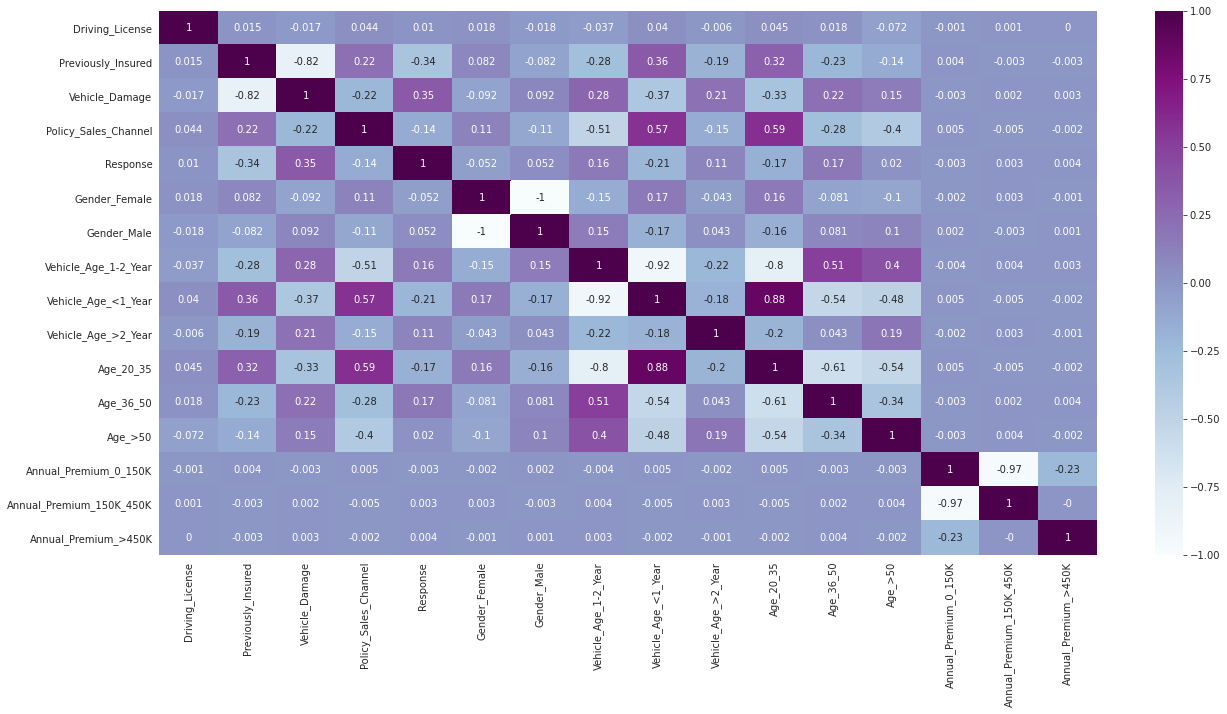

In [34]:
corr_= train_d.corr().round(3)
mask = np.zeros_like(corr_)
    
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(21, 10))
    ax = sns.heatmap(corr_, annot=True, cmap = "BuPu")

plt.tight_layout;
# plt.savefig('fig/matrix correlation.png');

In [35]:
train_d = train_d.drop([
    'Gender_Female', 
    'Driving_License',
    'Vehicle_Age_<1_Year', 
    'Annual_Premium_150K_450K',
    'Age_20_35'
], axis=1)
train_d.head()

,Previously_Insured,Vehicle_Damage,Policy_Sales_Channel,Response,Gender_Male,Vehicle_Age_1-2_Year,Vehicle_Age_>2_Year,Age_36_50,Age_>50,Annual_Premium_0_150K,Annual_Premium_>450K
0,0,1,-1.587234,1,1,0,1,1,0,1,0
1,0,0,-1.587234,0,1,1,0,0,1,1,0
2,0,1,-1.587234,1,1,0,1,1,0,1,0
3,1,0,0.737321,0,1,0,0,0,0,1,0
4,1,0,0.737321,0,0,0,0,0,0,1,0


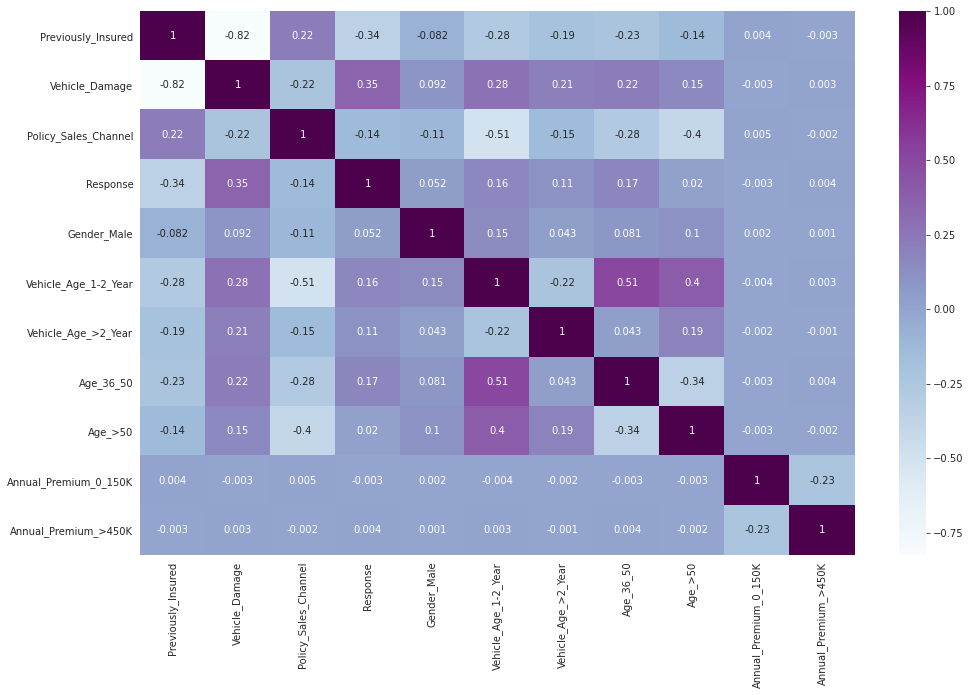

In [36]:
corr_= train_d.corr().round(3)
mask = np.zeros_like(corr_)
    
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr_, annot=True, cmap = "BuPu")

plt.tight_layout;
# plt.savefig('fig/matrix correlation.png');

<h1>CLASS IMBALANCE</h1>

In [37]:
# trr = train_d['Response'].value_counts().to_frame()
# trr['%'] = (trr['Response'] / len(train_d)) * 100
# trr

In [38]:
# from imblearn import over_sampling

# X = train_d.drop(['Response'],axis=1)
# y = train_d['Response']

# # Oversampling
# X_over, y_over = over_sampling.SMOTE().fit_resample(X, y)

In [39]:
# train_over = pd.concat([X_over, y_over], axis=1)
# train_over

In [40]:
# print(pd.Series(y_over).value_counts())

In [41]:
# train_over[train_over['Response'] == 1].duplicated().sum()

In [42]:
# train_over = train_over.drop_duplicates()
# train_over.head()

In [43]:
# trr2 = train_over['Response'].value_counts().to_frame()
# trr2['%'] = (trr2['Response'] / len(train_over)) * 100
# trr2

In [44]:
# list(train_over)

<h2>PRE-PROCESSING</h2>

In [45]:
# train.shape
# annualPrem = trains['Annual_Premium']
# maxValue = annualPrem.quantile(0.75) + (1.3 * (annualPrem.quantile(0.75) - annualPrem.quantile(0.25)))
# trains = trains.drop(trains[trains['Annual_Premium'] > maxValue].index)

In [46]:
# features = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
# plt.figure(figsize=(15, 7))
# for i in range(0, len(features)):
#     plt.subplot(1, 7, i+1)
#     sns.boxplot(train[features[i]],color='lime',orient='v')
#     plt.tight_layout()
    
# plt.savefig('fig/numerical boxplot.png')

In [47]:
# data_num = trains[features]
# k = len(data_num.columns)
# n = 3
# m = (k - 1) // n + 1
# fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
# for i, (name, col) in enumerate(data_num.iteritems()):
#     r, c = i // n, i % n
#     ax = axes[r, c]
#     col.hist(ax=ax, color='green')
#     ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, color='red')
#     ax2.set_ylim(0)

# fig.tight_layout()
# plt.savefig('fig/numerical distplot.png')


In [48]:
train = train_d

In [49]:
train.columns = list(train_d)

In [50]:
y = train['Response'].values
X = train.drop(labels = ['Response'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (381109, 10) and that of y is (381109,)


In [51]:
# Splitting the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of training set  (304887, 10)
Shape of test set  (76222, 10)


In [52]:
classifications = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

result_model = pd.DataFrame(columns = ['Method', 'roc_auc_score'])
result_model

,Method,roc_auc_score


In [53]:
for model in classifications:
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:,1]
    
    method = str(type(model)).split('.')[-1][:-2]

    
    #roc_auc_score
    roc_auc_score_ = roc_auc_score(y_test, y_score)
    roc_auc_score_ = roc_auc_score_.item()
    
    
    result_model = result_model.append({'Method': method,
                    'roc_auc_score': roc_auc_score_ * 100},
                     ignore_index=True)

In [54]:
result_model

,Method,roc_auc_score
0,LogisticRegression,83.775621
1,DecisionTreeClassifier,84.629840
2,RandomForestClassifier,84.829725


In [55]:
from sklearn import model_selection

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Get score:
results = model_selection.cross_val_score(rf, X, y, scoring='roc_auc')

In [56]:
results

array([0.84620113, 0.84773451, 0.84540123, 0.84544798, 0.84472796])

In [57]:
X_train

,Previously_Insured,Vehicle_Damage,Policy_Sales_Channel,Gender_Male,Vehicle_Age_1-2_Year,Vehicle_Age_>2_Year,Age_36_50,Age_>50,Annual_Premium_0_150K,Annual_Premium_>450K
45748,1,0,0.737321,0,0,0,0,0,1,0
150378,1,0,0.737321,1,0,0,0,0,1,0
27587,0,1,0.220753,0,1,0,0,1,1,0
282194,1,1,0.737321,0,0,0,0,0,1,0
45560,0,1,0.737321,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
73349,1,0,0.737321,0,0,0,0,0,1,0
371403,0,1,0.811117,0,1,0,1,0,1,0
312201,1,0,0.220753,1,1,0,1,0,1,0
267336,1,0,0.737321,0,1,0,1,0,1,0


In [61]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
clf.feature_importances_

array([2.86531763e-01, 3.68782764e-01, 1.83560240e-01, 6.80700811e-03,
       6.07072509e-02, 1.27638347e-02, 4.39417584e-02, 3.58793249e-02,
       8.51261006e-04, 1.74795206e-04])

<AxesSubplot:xlabel='importance', ylabel='index'>

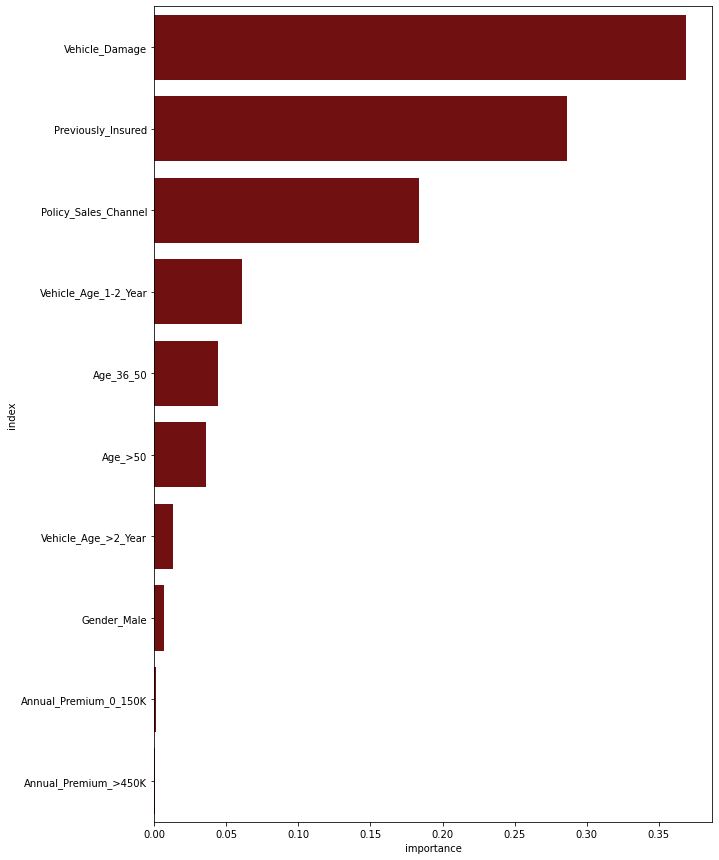

In [63]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,15))
sns.barplot(x='importance', y='index', color='#800000',data=feature_importances.reset_index())